In [1]:
import os
from collections import namedtuple, OrderedDict
import numpy as np
from skimage import io

import pyro
import pyro.optim as optim
# from pyro.infer import SVI, TraceGraph_ELBO
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate
import pyro.distributions as dist
import pyro.poutine as poutine
import pyro.contrib.examples.multi_mnist as multi_mnist
import torch
import torch.nn as nn
from torch.nn.functional import relu, tanh, sigmoid, softplus, grid_sample, affine_grid, avg_pool2d

import pandas as pd
import matplotlib.pyplot as plt

from sympy.solvers import solve
from sympy import Symbol, var
from sympy.solvers.diophantine import diophantine
from sympy.solvers.diophantine.diophantine import diop_solve
from sympy.solvers.diophantine.diophantine import diop_ternary_quadratic

In [2]:
torch.pi = torch.acos(torch.zeros(1)).item() * 2

In [3]:
device = torch.device('cuda:0')

In [4]:
torch.set_default_dtype(torch.float64)

In [5]:
def solve_padding_dilation(h_in, h_out, kernel_size=3, stride=1):
    H_in = Symbol("H_in", integer=True, positive=True)
    H_out = Symbol("H_out", integer=True, positive=True)
    padding = var("padding", integer=True, positive=True)
    dilation = var("dilation", integer=True, positive=True)
    # dilation=1
    # kernel_size = Symbol("kernel_size", integer=True)
    # kernel_size = 3
    # stride = Symbol("stride", integer=True)
    # stride = 1
    # m = Symbol("m", integer=True)

    H_in

    equation = (H_in + 2 * padding - dilation * (kernel_size - 1) - 1) / stride  + 1 - H_out
    # equation.subs({H_in:32, H_out:40, padding:0})
    
    for i in range(100):
        

        solution = diophantine(equation.subs({H_in:h_in, H_out:h_out, padding:i}))
        
        # print(solution)
        
        if len(solution) == 0:
            continue

        dilation_val = list(solution)[0][0]
        
        print(solution, dilation_val)
        if dilation_val > 0:
            padding_val = i
            break
    return padding_val, dilation_val

In [6]:
# led ~ 18cm, 1.8e8 nm; space between leds ~ 1.2cm, 1.2e7 nm

In [7]:
# height_grid = np.linspace(-1+0.5/4032, 1-0.5/4032, 4032)
# width_grid = np.linspace(-1+0.5/3036, 1-0.5/3036, 3036)



# xx, yy = np.meshgrid(width_grid, height_grid)

In [8]:
def bayer_mask(h, w, color="g"):
    mask = np.ones((h, w))

    if color == "g":
        for i in range(h):
            if i%2 == 0:
                mask[i, ::2] = 0
            else:
                mask[i, 1::2] = 0
                
    if color == "r":
        for i in range(h):
            if i%2 == 0:
                mask[i, 1::2] = 0
            else:
                mask[i, :] = 0
                
    if color == "b":
        for i in range(h):
            if i%2 == 0:
                mask[i, :] = 0
            else:
                mask[i, ::2] = 0
            
    return mask

In [9]:
image_small_green_mask = bayer_mask(128, 128)

In [10]:
# (led_x, led_y, led_z, object_height)
# position_loc = torch.tensor([16., 16., 19., 13.])
# position_scale = torch.tensor([0.5, 0.5, 0.5, 0.5])
position_loc = torch.tensor([0., 0., 0., 0.])
position_scale = torch.tensor([3, 3, 0.5, 0.5])
# # [upward_reflection, inner_reflection, refraction, outter_reflection]
# scattering_proportion_loc = torch.tensor([0., 0., 0., 0.])
# scattering_proportion_scale = torch.tensor([0.3, 0.3, 0.3, 0.3])
# # [relative position counterclockwisely]
# angles_loc = torch.tensor([0.5, 0.5, 0.5, 0.5])
# angles_scale = torch.tensor([0.5, 0.5, 0.5, 0.5])

# softmax; [undetected, same_side_reflection, refraction]
scattering_proportion_loc = torch.tensor([0., 0., 0.])
scattering_proportion_scale = torch.tensor([0.3, 0.3, 0.3])

# angle shift from reflection or fraction [−𝜋/4,𝜋/4]
angle_shift_loc = torch.tensor([0., 0.])
angle_shift_scale = torch.tensor([0.3, 0.3])

img_height = 128
img_width = 128
media_height = img_height * 4 # 512
media_width = img_width * 4 # 512
pixel_size = 1.85*1000
obixel_size = pixel_size / 4

# Load Dataset

In [11]:
dataset_root = "dataset"

In [12]:
image_files_path = []
for root, folders, files in os.walk(dataset_root):
    # print(p)
    if root == dataset_root:
        continue
    if len(files) == 0:
        continue
        
    for p in files:
        if p.endswith("bmp"):
            image_files_path.append(os.path.join(root, p))

In [13]:
image_files = [io.imread(p).T.astype(np.float64) for p in image_files_path]

In [14]:
image_files = np.stack(image_files, axis=0)

In [15]:
image_files.dtype

dtype('float64')

In [16]:
image_files_max = image_files.max()
image_files_min = image_files.min()
image_files = (image_files - image_files_min) / (image_files_max - image_files_min)

In [17]:
image_files[0].shape

(4032, 3036)

In [18]:
full_image_green_mask = bayer_mask(4032, 3036)

In [19]:
full_image_green_mask

array([[0., 1., 0., ..., 1., 0., 1.],
       [1., 0., 1., ..., 0., 1., 0.],
       [0., 1., 0., ..., 1., 0., 1.],
       ...,
       [1., 0., 1., ..., 0., 1., 0.],
       [0., 1., 0., ..., 1., 0., 1.],
       [1., 0., 1., ..., 0., 1., 0.]])

In [20]:
image_files_masked = [i * full_image_green_mask for i in image_files]

In [21]:
image_single = image_files_masked[0]

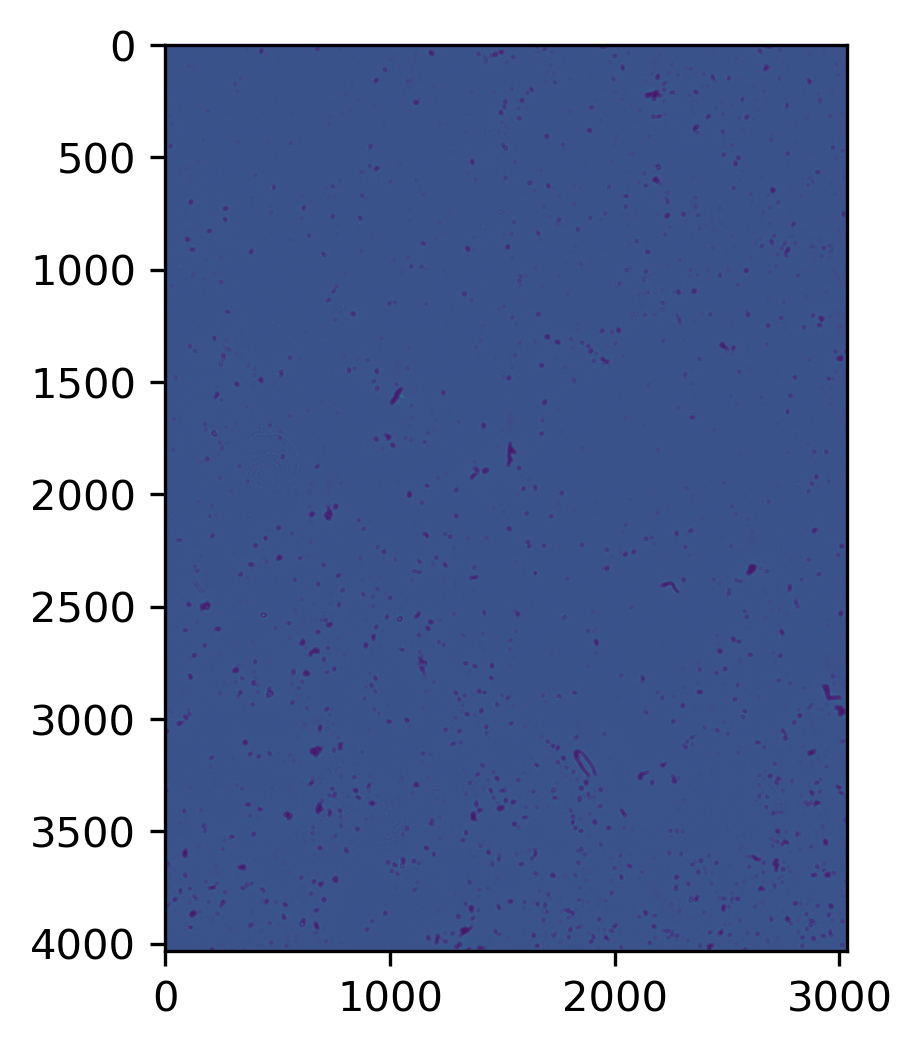

In [22]:
fig = plt.figure(dpi=300)
plt.imshow(image_single)

In [23]:
image_full_height, img_full_width = image_single.shape

y_full_idx = np.arange(4032*4)
x_full_idx = np.arange(3036*4)
xx_full_idx, yy_full_idx = np.meshgrid(x_full_idx, y_full_idx)

In [24]:
yy_full_geo = (yy_full_idx+0.5-4032/2)*obixel_size*-1
xx_full_geo = (xx_full_idx+0.5-3036/2)*obixel_size

In [25]:
obixel_full_grid = np.stack([xx_full_geo, yy_full_geo], axis=-1)

In [26]:
image_smalls = []
obixel_full_grid_smalls = []
for i in range(0, 4032, 128):
    for j in range(0, 3036, 128):
        
        if j+128 >= 3036:
            continue
        if i+128 >= 4032:
            continue
            
        image_smalls.append(image_single[i:i+128, j:j+128])
        obixel_full_grid_smalls.append(obixel_full_grid[i*4:(i+128)*4, j*4:(j+128)*4])

In [27]:
image_smalls = np.stack(image_smalls, axis=0)
image_smalls = torch.from_numpy(image_smalls)

In [28]:
image_smalls.shape

torch.Size([713, 128, 128])

In [29]:
obixel_full_grid_smalls = np.stack(obixel_full_grid_smalls, axis=0)
obixel_full_grid_smalls = torch.from_numpy(obixel_full_grid_smalls)

In [30]:
obixel_full_grid_smalls.dtype

torch.float64

In [31]:
# obixel_grid

# Model

# $\theta$ and $\phi$
    \
     \
      \
    ...\..............                     
    ....\.............                                L                    \                                   
    .....\............                              .                       \    __ undetected                   
    ......\..𝜙........                            .                          \    /|                  
    .......\..........                          .   𝜃                         \  /             
    ..................                   P....................                 \/                   
    ..................                  .   .                                  /\                   
    ..................                 .  .                                   /  \                       
    ..................                . .                                    /    \ outgoing                     
    ..................           ....O..............                    ingoing                               

## shift of x and y
$x = h \cdot \tan(\theta) \cdot \cos(\phi)$ 

$y = h \cdot \tan(\theta) \cdot \sin(\phi)$

Suppose $x_i$ is the light distance in a same pixel, and $\delta$ is the phase shift
$$\int_0^{2\pi} | \sum_i{sin(kx_i + \delta)} |\ d\delta $$

$$\int_0^{2\pi} | \sum_i{sin(\frac{2\pi}{490}x_i + \delta)} |\ d\delta $$

In [32]:
# x_idx = torch.arange(media_width)
# y_idx = torch.arange(media_height)

# yy_idx, xx_idx = torch.meshgrid(y_idx, x_idx)

# yy_geo = (yy_idx+0.5-media_height/2)*obixel_size*-1
# xx_geo = (xx_idx+0.5-media_width/2)*obixel_size

# obixel_grid = torch.stack([xx_geo, yy_geo], axis=-1).to(device=device)

In [33]:
# Location on Sensor Corresponding to Image
#    Upper-Left ---------------Bottom-Left
#         |                         |
#         |                         |
#    Upper-Right---------------Botttom-Right

In [34]:
invalid_scattering_threshold = 0.46 # 0.46*pi
wavelenghth = 490 # nm
omega = 2*torch.pi/wavelenghth
n_phase_grid = 10
phase_shift_grid = torch.linspace(0, wavelenghth, n_phase_grid).expand(1, media_height, media_width, n_phase_grid).to(device=device)
# phase_shift_grid

In [35]:
def scattering_amplitude(n, shift_x, shift_y, obixel_grid, amplitude, batch_indices):
    
    target_index_x = (obixel_grid[..., 0:1] + shift_x)/obixel_size + media_width/2 - 0.5
    target_index_y = -(obixel_grid[..., 1:2] + shift_y)/obixel_size + media_height/2 - 0.5
    
    target_index_x = torch.clamp(target_index_x, 0, media_width/2)
    target_index_y = torch.clamp(target_index_y, 0, media_height/2)
    
    target_index_x_round = target_index_x.round()
    target_index_y_round = target_index_y.round()
    target_index_x_idx = target_index_x_round.long()
    target_index_y_idx = target_index_y_round.long()
    
    scattering_weight = \
        (1-torch.abs(target_index_x_round - target_index_x)) * \
        (1-torch.abs(target_index_y_round - target_index_y))
    
    # scattering_weight = torch.abs(scattering_weight)
    amplitude  = amplitude * scattering_weight
    
    # batch_indices = torch.zeros((target_index_x.shape[0],), dtype=int)
    # batch_indices = torch.arange(n).reshape(n, 1).expand(n, 512*512).reshape(-1)
    amplitude_target = torch.zeros_like(amplitude).index_put_(
        [
            # torch.tensor([0]),
            batch_indices,
            target_index_y_idx.reshape(-1), 
            target_index_x_idx.reshape(-1),
        ],
        amplitude.reshape(n, -1, n_phase_grid),
        accumulate=True
    )
    
    
    # amplitude_target = torch.abs(amplitude_target).sum(axis=-1)
    
    return amplitude_target

In [36]:
# obixel_grid/obixel_size

In [37]:
import math
math.log10

<function math.log10(x, /)>

In [38]:
# 1 mm = 1e6 nm
position_start = torch.tensor([0, 0, 1.8e8, 1e6]).reshape(1, -1).to(device=device)
position_factor = torch.tensor([5e7, 5e7, 1e7, 0.9e6]).to(device=device)

In [39]:
print(position_start)
print(position_factor)

tensor([[0.0000e+00, 0.0000e+00, 1.8000e+08, 1.0000e+06]], device='cuda:0')
tensor([50000000., 50000000., 10000000.,   900000.], device='cuda:0')


In [40]:
image_small_green_mask = torch.from_numpy(image_small_green_mask).to(device=device)

In [41]:
def prior_sketch(n, obixel_grid, real_x=None, real_y=None, real_z=None, real_h=None):
    
    position = pyro.sample("position", dist.Normal(
            position_loc.expand(n, -1),
            position_scale.expand(n, -1)
        ).to_event(1)
    ).cuda(device=device)
    
    position = torch.tanh(position)
    position = position * position_factor + position_start
        
    # position_relative = position[..., :2].view(n, 1, 1, 2) - obixel_grid.unsqueeze(0)
    position_relative = position[..., :2].view(n, 1, 1, 2) - obixel_grid
    
    pos_x = position_relative[..., 0:1]
    pos_y = position_relative[..., 1:2]
    pos_z = position[..., 2:3][:, None, None]
    pos_h = position[..., 3:4][:, None, None]
    
    # phi = torch.asin(pos_y / torch.sqrt(pos_x*pos_x + pos_y*pos_y))
    phi_ingoing = torch.atan2(pos_y, pos_x) 
    phi_outgoing = phi_ingoing + torch.pi
    
    # print(pos_x.shape, pos_z.shape)
    theta =  torch.atan(torch.exp( torch.log(torch.sqrt(pos_x*pos_x + pos_y*pos_y)) - torch.log(pos_z) ))
    
    
    scattering_proportion = pyro.sample("scattering_proportion", dist.Normal(
            scattering_proportion_loc.expand(n, media_height, media_width, 3),
            scattering_proportion_scale.expand(n, media_height, media_width, 3)
        ).to_event(3)
    ).cuda(device=device)
    scattering_proportion = torch.softmax(scattering_proportion, axis=-1)
    
    angle_shift = pyro.sample("angle_shift", dist.Normal(
            angle_shift_loc.expand(n, media_height, media_width, 2),
            angle_shift_scale.expand(n, media_height, media_width, 2)
        ).to_event(3)
    ).cuda(device=device)
    angle_shift = torch.tanh(angle_shift) * torch.pi / 4
    
    # atan(8/1) ~ 0.46, speciman height 1 mm, sensor size 8 mm
    theta_ingoing = torch.clamp(theta + angle_shift[..., 0:1], 0, torch.pi * invalid_scattering_threshold)
    theta_outgoing = torch.clamp(theta + angle_shift[..., 1:2], 0, torch.pi * invalid_scattering_threshold)
    
    # ingoing side light
    ingoing_reflection = scattering_proportion[..., 1:2]
    outgoing_refaction = scattering_proportion[..., 2:3]
    
    # shift_x, shift_y on the same side
    ingoing_modulus = pos_h * torch.tan(theta_ingoing)
    ingoing_light_distance = pos_h / torch.cos(theta_ingoing)
    ingoing_shift_x = ingoing_modulus * torch.cos(phi_ingoing)
    ingoing_shift_y = ingoing_modulus * torch.sin(phi_ingoing) 
    
    # shift_x, shift_y on the other side
    outgoing_modulus = pos_h * torch.tan(theta_outgoing)
    outgoing_light_distance = pos_h / torch.cos(theta_outgoing)
    outgoing_shift_x = outgoing_modulus * torch.cos(phi_outgoing)
    outgoing_shift_y = outgoing_modulus * torch.sin(phi_outgoing) 
    
    # ingoing amplitude
    ingoing_amplitude = torch.sin(omega * ingoing_light_distance + \
                                  phase_shift_grid) * scattering_proportion[..., 1:2]
    # move amplitude with shift_x, and shift_y
    
    # outgoing amplitude
    outgoing_amplitude = torch.sin(omega * outgoing_light_distance + \
                                   phase_shift_grid) * scattering_proportion[..., 2:3]
    
    
    batch_indices = torch.arange(n).reshape(n, 1).expand(n, media_height*media_width).reshape(-1)
    ingoing_amplitude_target = scattering_amplitude(
        n, ingoing_shift_x, ingoing_shift_y, obixel_grid, ingoing_amplitude, batch_indices)
    outgoing_amplitude_target = scattering_amplitude(
        n, outgoing_shift_x, outgoing_shift_y, obixel_grid, outgoing_amplitude, batch_indices)
    
    sensor_detected = ingoing_amplitude + outgoing_amplitude
    sensor_detected = torch.abs(sensor_detected).mean(axis=-1, keepdim=True)
    # sensor_detected = sensor_detected.unsqueeze(1)
    sensor_detected = torch.permute(sensor_detected, (0, 3, 1, 2))
    
    # subsample every 4x4 obixel to one pixel
    sensor_detected = avg_pool2d(sensor_detected, kernel_size=4, stride=4)
    
    # sensor_detected = torch.abs(sensor_detected).mean(axis=-1, keepdim=True)
    
    return sensor_detected

In [42]:
# sensor_detected = prior_sketch(2, obixel_grid)

In [43]:
sensor_detected_sd = torch.tensor([[[0.1]]])

def model(images, obixel_grids):
    
    with pyro.plate("images", images.size(0)) as indices:
       
        batch_obixel_grid = obixel_grids[indices].to(device=device)
        n = batch_obixel_grid.size(0)
        # print("n: ", n)
        # n = 4
        
        batch_images = images[indices] #.view(n, 1, img_height, img_width)
        
        sensor_detected = prior_sketch(n, batch_obixel_grid).cpu()
        
        # print("sensor_detected.shape: ", sensor_detected.shape)
        # print("batch_images.shape: ", batch_images.shape)
        
        pyro.sample(
            "obs", 
            dist.Normal(sensor_detected, sensor_detected_sd.expand(n, 1, img_height, img_width)).to_event(3),
            # dist.Normal(sensor_detected, sensor_detected*0.1).to_event(2),
            obs=batch_images
        )

In [44]:
class PredictPosition(nn.Module):
    def __init__(self ,use_cuda=True, *args, **kargs):
        super().__init__(*args, **kargs)
        
        
        # 128x128 -> 64x64
        self.c1 = nn.Conv2d(1, 16, 3, 1, padding="same")
        self.p1 = nn.MaxPool2d(2, stride=2)
        
        # 64x64 -> 32x32
        self.c2 = nn.Conv2d(16, 32, 3, 1, padding="same")
        self.p2 = nn.MaxPool2d(2, stride=2)
        
        # 32x32 -> 16x16
        self.c3 = nn.Conv2d(32, 64, 3, 1, padding="same")
        self.p3 = nn.MaxPool2d(2, stride=2)
        
        # 16x16 -> 8x8
        self.c4 = nn.Conv2d(64, 128, 3, 1, padding="same")
        self.p4 = nn.MaxPool2d(2, stride=2)
        
        # 16x16 -> 4x4
        self.c5 = nn.Conv2d(128, 256, 3, 1, padding="same")
        self.p5 = nn.MaxPool2d(2, stride=2)
        
        self.f = nn.Flatten()
        self.l = nn.Linear(256*4*4, 8)
        
        if use_cuda:
            self.cuda(device=device)
        
    def forward(self, images):
        
        h = self.c1(images)
        h = tanh(h)
        h = self.p1(h)
        
        h = self.c2(h)
        h = tanh(h)
        h = self.p2(h)
        
        h = self.c3(h)
        h = tanh(h)
        h = self.p3(h)
        
        h = self.c4(h)
        h = tanh(h)
        h = self.p4(h)
        
        h = self.c5(h)
        h = tanh(h)
        h = self.p5(h)
        
        h = self.f(h)
        a = self.l(h)
        
        # z_pres_p = sigmoid(a[:, 0:1]) # Squish to [0,1]
        # z_where_loc = a[:, 1:4]
        # z_where_scale = softplus(a[:, 4:]) # Squish to >0
        # return z_pres_p, z_where_loc, z_where_scale
        
        position_loc = a[:, 0:4]
        position_scale = softplus(a[:, 4:])
        
        return position_loc, position_scale

In [45]:
# predict the scattering proportion and corresponding angles
class PredictMedia(nn.Module):
    def __init__(self, use_cuda=True, *args, **kargs):
        super().__init__(*args, **kargs)
        
        # 128x128 -> 256x256
        self.c1a = nn.Conv2d(1, 128, 3, padding="same")
        self.t1  = nn.ConvTranspose2d(128, 32, 2, stride=2)
        
        
        # 256x256 -> 512x512
        self.c2a = nn.Conv2d(32, 64, 3, padding="same")
        self.t2  = nn.ConvTranspose2d(64, 16, 2, stride=2)
        
        
        # 512x512 -> 1024x1024
        self.c3a = nn.Conv2d(16, 32, 3, padding="same")
        self.t3  = nn.ConvTranspose2d(32, 8, 2, stride=2)
        
        
        # 1024x1024 -> 512x512
        self.c4a = nn.Conv2d(8, 16, 3, padding="same")
        self.p4 = nn.MaxPool2d(2, stride=2)
        
        self.cn = nn.Conv2d(16, 10, 3, padding="same")
        
        if use_cuda:
            self.cuda(device=device)

    def forward(self, images):

        
        h = self.c1a(images)
        h = tanh(h)
        h = self.t1(h)
        h = tanh(h)
        

        h = self.c2a(h)
        h = tanh(h)
        h = self.t2(h)
        h = tanh(h)
        
        h = self.c3a(h)
        h = tanh(h)
        h = self.t3(h)
        h = tanh(h)
        
        h = self.c4a(h)
        h = tanh(h)         
        h = self.p4(h)
       
                 

        a = self.cn(h)
        # h = tanh(h)

        # 3 scattering proportion, 2 angles
        
        
        scattering_proportion_loc = a[:, :3]
        scattering_proportion_scale = softplus(a[:, 3:6])
        
        angle_shift_loc = a[:, 6:8]
        angle_shift_scale = softplus(a[:, 8:10])
        
        scattering_proportion_loc = torch.permute(scattering_proportion_loc, (0, 2, 3, 1))
        scattering_proportion_scale = torch.permute(scattering_proportion_scale, (0, 2, 3, 1))
        
        angle_shift_loc = torch.permute(angle_shift_loc, (0, 2, 3, 1))
        angle_shift_scale = torch.permute(angle_shift_scale, (0, 2, 3, 1))

        return scattering_proportion_loc, scattering_proportion_scale, angle_shift_loc, angle_shift_scale

In [46]:
predict_position = PredictPosition(use_cuda=True)
predict_media = PredictMedia(use_cuda=True)

In [47]:
def guide(images, obixel_grids):
    
    pyro.module("predict_position", predict_position)
    pyro.module("predict_media", predict_media)
    
    with pyro.plate("images", images.size(0), subsample_size=4) as indices:
        
        n = indices.size(0)
        
        # images should be in shape (n, c, h, w)
        batch_images = images[indices].to(device=device)
        
        # predict location
        position_loc, position_scale = predict_position(batch_images)
        scattering_proportion_loc, scattering_proportion_scale, angle_shift_loc, angle_shift_scale = predict_media(batch_images)
        
        
        pyro.sample("position", dist.Normal(
                position_loc.cpu(),
                position_scale.cpu()
            ).to_event(1)
        ).cuda(device=device)
        
        # predict proportion and angle shift
        
        # print("scat_prop_loc.shape: ", scattering_proportion_loc.shape)
        # print("scat_prop_scale.shape: ", scattering_proportion_scale.shape)
        
        pyro.sample("scattering_proportion", dist.Normal(
                scattering_proportion_loc.cpu(),
                scattering_proportion_scale.cpu()
            ).to_event(3)
        ).cuda(device=device)
        
        pyro.sample("angle_shift", dist.Normal(
                angle_shift_loc.cpu(),
                angle_shift_scale.cpu()
            ).to_event(3)
        ).cuda(device=device)
        
        
    
    

In [48]:
optimizer = optim.Adam({'lr': 1e-4})

In [49]:
svi = SVI(model,
          guide,
          optimizer,
          loss=Trace_ELBO()
         )

In [50]:
img_height

128

In [51]:
image_smalls = image_smalls.view(-1, 1, img_height, img_width)#.to(device=device)

In [52]:
image_smalls.dtype

torch.float64

In [53]:
obixel_full_grid_smalls = obixel_full_grid_smalls#.to(device=device)

In [ ]:
losses = []
last_loss = 0
for i in range(0, int(150000)):
    loss = svi.step(image_smalls, obixel_full_grid_smalls)
    if loss < last_loss:
        last_loss = loss
        print("Improvement! ")
    print('i={}, elbo={:.2f}'.format(i, loss / image_smalls.size(0)))
    losses.append(loss)

/home/lachlan/miniconda3/envs/lensless/lib/python3.7/site-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/lachlan/miniconda3/envs/lensless/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


i=0, elbo=1725151.11
i=1, elbo=1713292.80
i=2, elbo=1700688.63
i=3, elbo=1686576.34
i=4, elbo=1675314.77
i=5, elbo=1663312.26


In [55]:
scattering_proportion_loc, scattering_proportion_scale, angle_shift_loc, angle_shift_scale = predict_media(image_smalls[:4].view(4, 1, img_height, img_width).to(device=device))

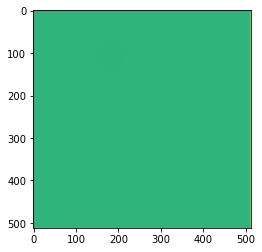

In [58]:
plt.imshow(torch.softmax(angle_shift_loc[3], axis=-1)[..., 1].cpu().detach())

In [57]:
angle_shift_loc.shape

torch.Size([4, 512, 512, 2])

In [69]:
image_smalls.shape

torch.Size([713, 128, 128])

In [70]:
obixel_full_grid_smalls.shape

(713, 512, 512, 2)

In [63]:
guide(image_smalls, obixel_full_grid_smalls)

In [182]:
sensor_detected

tensor([[[0.3010, 0.3032, 0.3165,  ..., 0.3331, 0.3246, 0.3215],
         [0.3837, 0.3257, 0.3165,  ..., 0.3620, 0.3222, 0.3224],
         [0.3088, 0.3334, 0.3908,  ..., 0.3746, 0.3526, 0.2657],
         ...,
         [0.3260, 0.3181, 0.3506,  ..., 0.3034, 0.3576, 0.3033],
         [0.3193, 0.3011, 0.3203,  ..., 0.3225, 0.3646, 0.3583],
         [0.3108, 0.3466, 0.3390,  ..., 0.3125, 0.3343, 0.2860]],

        [[0.2631, 0.3158, 0.3171,  ..., 0.3119, 0.3303, 0.3904],
         [0.3375, 0.2939, 0.3248,  ..., 0.3543, 0.2874, 0.3484],
         [0.3048, 0.3080, 0.3117,  ..., 0.3523, 0.2768, 0.3376],
         ...,
         [0.2468, 0.2885, 0.2774,  ..., 0.2801, 0.3614, 0.2909],
         [0.3556, 0.3478, 0.3083,  ..., 0.3196, 0.3449, 0.3228],
         [0.3046, 0.3476, 0.3086,  ..., 0.2608, 0.3444, 0.3155]]],
       device='cuda:0')

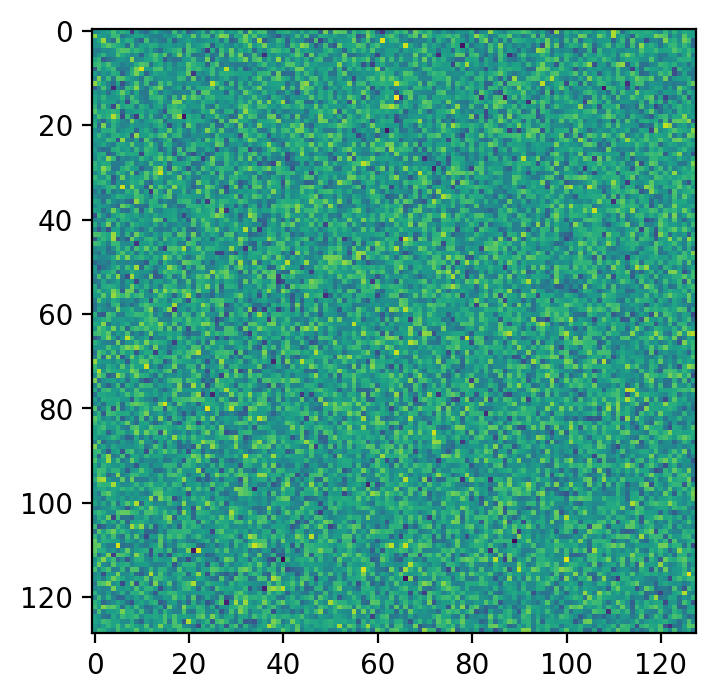

In [183]:
fig = plt.figure(dpi=200)
plt.imshow(sensor_detected[0].cpu())